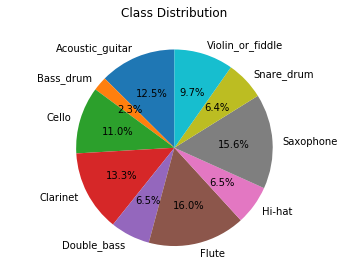

100%|██████████| 26410/26410 [01:15<00:00, 349.11it/s]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 13, 32)         4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 13, 64)         18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 6, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
__________

In [2]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config



def check_data():
    if os.path.isfile(config.p_path):
        print('Loading exixting data for {}'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None




df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()



n_samples = 2* int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p= prob_dist)
# making probability 



        
        
def build_rand_feat():
    
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    
    X=[]
    y=[]
    _min,_max = float('inf'),-float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=prob_dist)
        file=np.random.choice(df[df.label==rand_class].index)
        rate,wav =wavfile.read('clean/'+file)
        label = df.at[file,'label']
        rand_index = np.random.randint(0,wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample,rate,numcep=config.nfeat,nfilt=config.nfilt,nfft=config.nfft)
        
        _min = min(np.amin(X_sample),_min)
        _max = max(np.amax(X_sample),_max)
        
        X.append(X_sample)
        y.append(classes.index(label))
        
        
        
        config.min = _min
        config.max = _max
        
    X,y = np.array(X),np.array(y)
    X = (X - _min)/(_max - _min)
    
    if config.mode =='conv':
        X=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    elif config.mode == 'time':
         X=X.reshape(X.shape[0],X.shape[1],X.shape[2])
            
    y=to_categorical(y,num_classes=10)
    
    config.data = (X,y)
    
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config,handle,protocol=2)  #or protocol=Highest_protocol
    
    return X,y


def get_conv_model():
    model=Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    
    return model



config = Config(mode='conv')

if config.mode=='conv':
    X,y = build_rand_feat()
    y_flat = np.argmax(y,axis=1)
    input_shape = (X.shape[1],X.shape[2],1)
    model= get_conv_model()
    
elif config.mode=='time':
    X,y=build_rand_feat()
    y_flat = np.argmax(y,axis=1)
    input_shape = (X.shape[1],X.shape[2])
    model= get_recurrent_model()
    
class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat) 

checkpoint = ModelCheckpoint(config.model_path,monitor='val_acc',verbose=1,mode='max',save_best_only=True, save_weights_only=False, period=1)


model.fit(X,y,epochs=10,batch_size=32,shuffle=True,validation_split=0.1,callbacks=[checkpoint])

model.save(config.model_path)
    
    

def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(128,return_sequences=True,input_shape=input_shape))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))
    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    
    
    return model

